# Exploration of geographically weighted random forest classification modelling

To-do:
- [x] global model
- [x] model evaluation
- [x] bandwidth optimisation
- [x] feature importances
- [x] golden section bandwidth selection
- [x] other metrics than accuracy
- [x] generic support (logistic regression, gradient boosting)
- [x] dedicated classes
- [ ] local performance of models that do not support OOB
    - [x] with logistic regression I guess we can do predict_proba and measure those on the full sample directly
    - with gradient boosting we can't as the model has seen the data - might need to split to train/test to mimic OOB.
- [x] logistic regression local coefficients
- [x] (optionally) predict method

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from geodatasets import get_path
from sklearn import metrics, preprocessing

from gwlearn.ensemble import GWGradientBoostingClassifier, GWRandomForestClassifier
from gwlearn.linear_model import GWLogisticRegression
from gwlearn.search import BandwidthSearch


Get sample data

In [2]:
gdf = gpd.read_file(get_path("geoda.ncovr"))

In [3]:
gdf.shape

(3085, 70)

In [4]:
# It is in the geographic coords in the  US and we need to work with distances. Re-project and use only points as the graph builder will require points anyway.
gdf = gdf.set_geometry(gdf.representative_point()).to_crs(5070)

In [5]:
y = gdf["FH90"] > gdf["FH90"].median()

### Random forest

In [6]:
gwrf = GWRandomForestClassifier(
    geometry=gdf.geometry,
    bandwidth=250,
    fixed=False,
    n_jobs=-1,
    keep_models=False,
)
gwrf.fit(
    gdf.iloc[:, 9:15],
    y,
)

,bandwidth,250
,fixed,False
,kernel,'bisquare'
,include_focal,False
,geometry,0 PO...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,measure_performance,True
,strict,False
,keep_models,False


Global OOB accuracy for the GW model measured based on OOB predictions from individual local trees.

In [7]:
gwrf.pooled_oob_score_

0.7642770562770563

In [8]:
gwrf.pooled_oob_precision_

0.7679759330768221

In [9]:
gwrf.pooled_oob_recall_

0.7632937638601863

In [10]:
gwrf.pooled_oob_balanced_accuracy_

0.7642858242008288

Local OOB accuracy.

<Axes: >

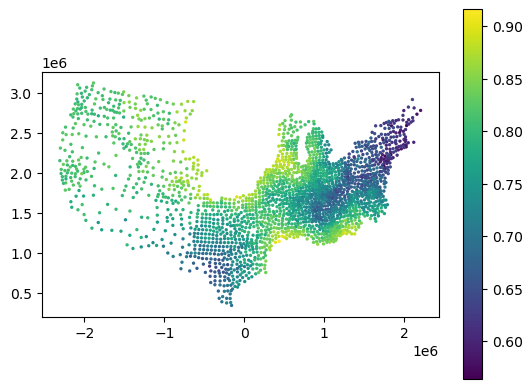

In [11]:
gdf.plot(gwrf.local_oob_score_, legend=True, s=2)

<Axes: >

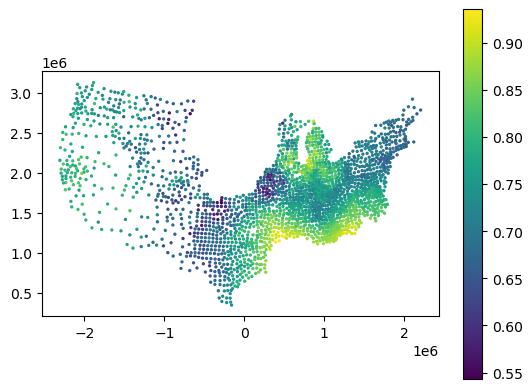

In [12]:
gdf.plot(gwrf.local_oob_precision_, legend=True, s=2)

<Axes: >

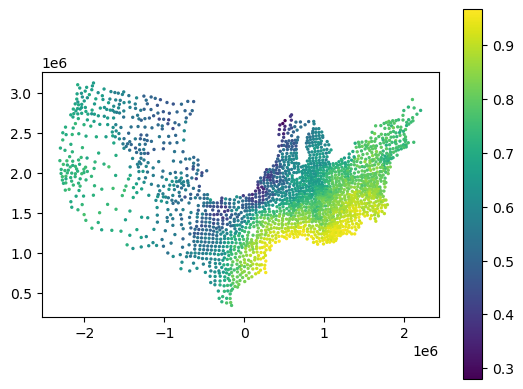

In [13]:
gdf.plot(gwrf.local_oob_recall_, legend=True, s=2)

<Axes: >

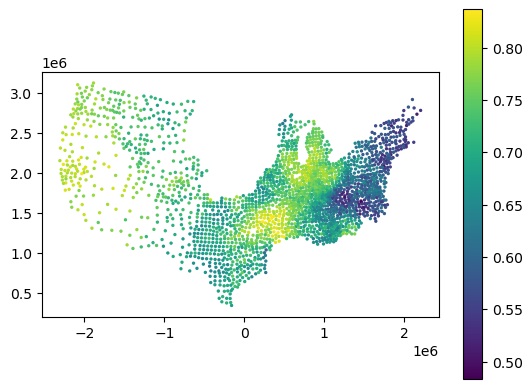

In [14]:
gdf.plot(gwrf.local_oob_balanced_accuracy_, legend=True, s=2)

<Axes: >

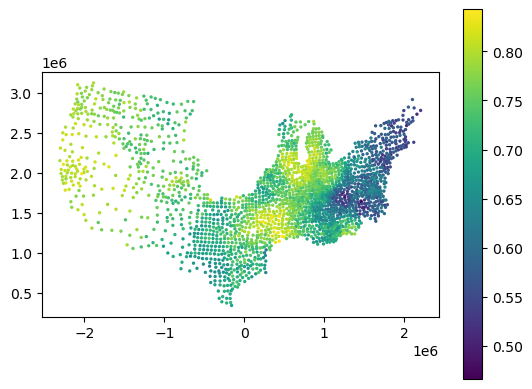

In [15]:
gdf.plot(gwrf.local_oob_f1_macro_, legend=True, s=2)

<Axes: >

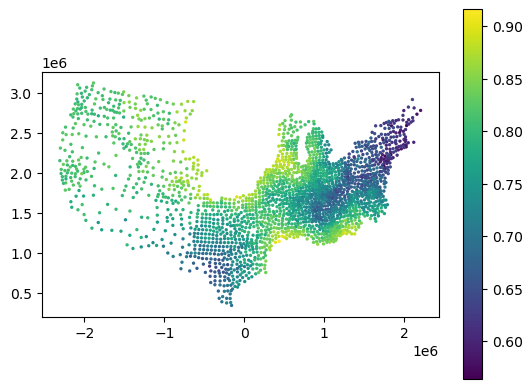

In [16]:
gdf.plot(gwrf.local_oob_f1_micro_, legend=True, s=2)

<Axes: >

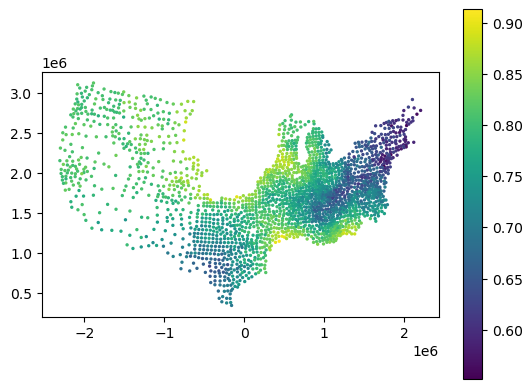

In [17]:
gdf.plot(gwrf.local_oob_f1_weighted_, legend=True, s=2)

<Axes: >

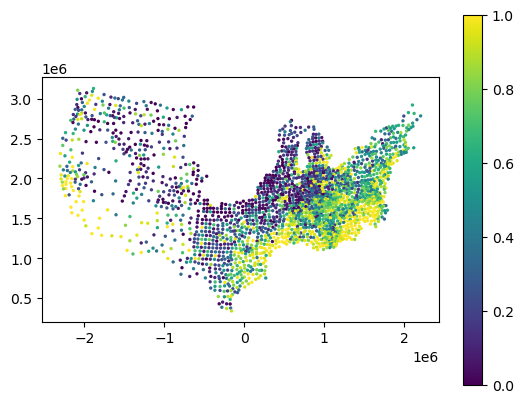

In [18]:
gdf.plot(gwrf.proba_[True], legend=True, s=2)

<Axes: >

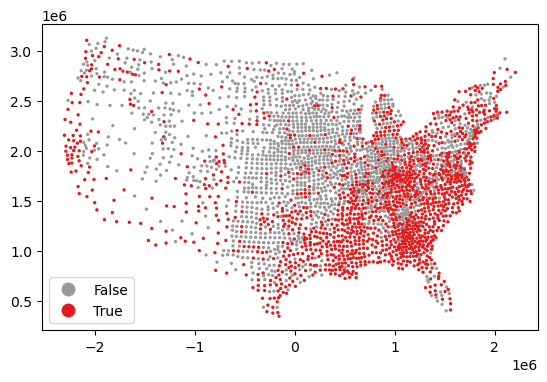

In [19]:
gdf.plot(y, legend=True, s=2, cmap="Set1_r")

Global accuracy for the GW model measured based on prediction of focals.

In [20]:
gwrf.focal_score_

0.7688311688311689

F1 scores for the GW model measured based on prediction of focals. 

In [21]:
gwrf.focal_f1_macro_, gwrf.focal_f1_micro_, gwrf.focal_f1_weighted_

(0.7686423054070113, 0.7688311688311689, 0.768894123305888)

OOB score (accuracy) of the global model.

In [22]:
gwrf.global_model.oob_score_

0.7857374392220421

Get local feature importances.

In [23]:
gwrf.feature_importances_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.144477,0.132334,0.128224,0.159942,0.224753,0.210269
2,0.157417,0.131966,0.129957,0.163009,0.201650,0.216002
3,0.149385,0.150804,0.121830,0.158391,0.159365,0.260225
4,0.150746,0.126414,0.133151,0.168743,0.188069,0.232876
...,...,...,...,...,...,...
3080,0.159566,0.092755,0.200158,0.100452,0.266964,0.180106
3081,0.145268,0.106852,0.149962,0.205229,0.226562,0.166127
3082,0.135004,0.191319,0.196336,0.229536,0.101454,0.146351
3083,0.157471,0.179052,0.172274,0.258900,0.101638,0.130664


<Axes: >

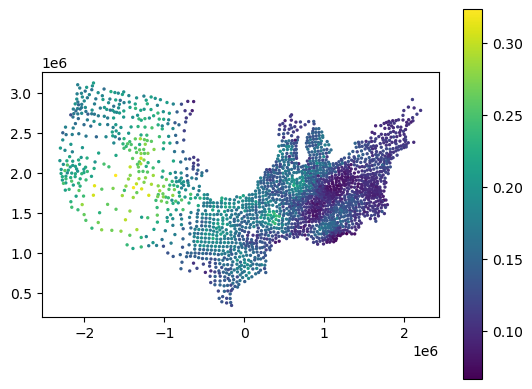

In [24]:
gdf.plot(gwrf.feature_importances_["HC60"], legend=True, s=2)

Compare to global feature importance.

In [25]:
gwrf.global_model.feature_importances_

array([0.1376211 , 0.14922522, 0.18811756, 0.18455711, 0.15414063,
       0.18633837])

### Gradient boosting

In [26]:
gwgb = GWGradientBoostingClassifier(
    geometry=gdf.geometry,
    bandwidth=250,
    fixed=False,
    n_jobs=-1,
    keep_models=False,
)
gwgb.fit(
    gdf.iloc[:, 9:15],
    y,
)

,bandwidth,250
,fixed,False
,kernel,'bisquare'
,include_focal,False
,geometry,0 PO...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,measure_performance,True
,strict,False
,keep_models,False


Global score (accuracy) for the GW model measured based on prediction of focals using focal model only.

In [27]:
gwgb.focal_score_

0.7532467532467533

F1 scores for the GW model measured based on prediction of focals. 

In [28]:
gwgb.focal_f1_macro_, gwgb.focal_f1_micro_, gwgb.focal_f1_weighted_

(0.7530688699117222, 0.7532467532467533, 0.7533213494840244)

Get local feature importances.

In [29]:
gwgb.feature_importances_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.177324,0.128130,0.061830,0.156487,0.153590,0.322639
2,0.191413,0.128259,0.065317,0.159779,0.122753,0.332479
3,0.150581,0.136845,0.076695,0.168919,0.069886,0.397074
4,0.176430,0.126904,0.076155,0.152064,0.113692,0.354755
...,...,...,...,...,...,...
3080,0.108860,0.050411,0.147236,0.050985,0.578005,0.064505
3081,0.085776,0.070274,0.137502,0.213598,0.457443,0.035408
3082,0.107440,0.195233,0.192253,0.313614,0.066126,0.125333
3083,0.147868,0.145626,0.156851,0.384657,0.044400,0.120598


<Axes: >

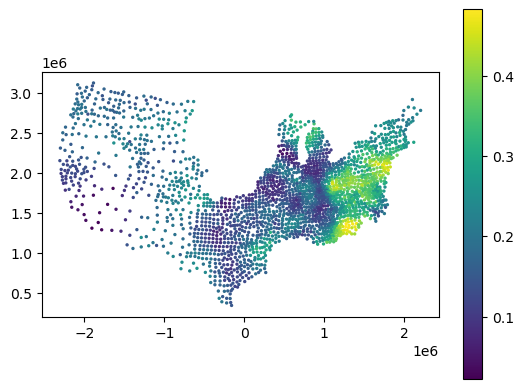

In [30]:
gdf.plot(gwgb.feature_importances_["HR90"], legend=True, s=2)

Compare to global feature importance.

In [31]:
gwgb.global_model.feature_importances_

array([0.05122282, 0.05589   , 0.12284528, 0.15103731, 0.22564836,
       0.39335622])

### Logistic regression

In [32]:
gwlr = GWLogisticRegression(
    geometry=gdf.geometry,
    bandwidth=900_000,
    fixed=True,
    n_jobs=-1,
    keep_models=True,
    max_iter=500,
)
gwlr.fit(
    pd.DataFrame(
        preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
    ),
    gdf["FH90"] > gdf["FH90"].median(),
)

/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,bandwidth,900000
,fixed,True
,kernel,'bisquare'
,include_focal,True
,geometry,0 PO...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,measure_performance,True
,strict,False
,keep_models,True


In [33]:
gwlr.focal_score_

0.7991746905089409

In [34]:
gwlr.focal_f1_micro_

0.7991746905089409

<Axes: >

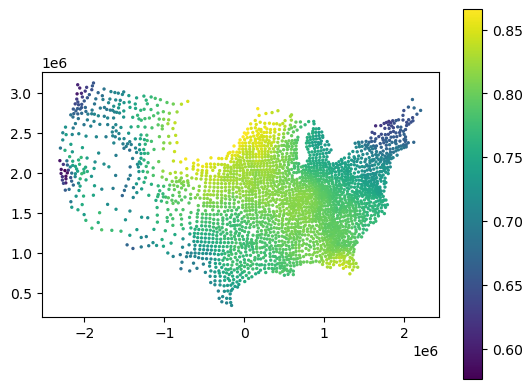

In [38]:
gdf.plot(gwlr.local_score_, legend=True, s=2)

In [39]:
gwlr.pooled_f1_macro_, gwlr.pooled_f1_micro_, gwlr.pooled_f1_weighted_

(0.7867537109649924, 0.7869420636659645, 0.7870271397918338)

Local coefficients

In [40]:
gwlr.local_coef_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.309215,0.164623,0.037579,0.258089,1.440022,0.918536
2,0.315430,0.165743,0.053384,0.259558,1.454450,0.904669
3,0.314561,0.166154,0.014911,0.260348,1.376091,0.914176
4,0.322282,0.168002,0.066870,0.261307,1.454912,0.884666
...,...,...,...,...,...,...
3080,0.066790,0.452212,0.537811,-0.062854,1.140241,0.753478
3081,0.112027,0.112244,0.584092,0.352214,1.577165,0.871271
3082,-0.105918,0.494388,0.321603,0.658542,1.832182,1.244258
3083,-0.168077,0.487770,0.378523,0.613317,2.114276,1.437605


<Axes: >

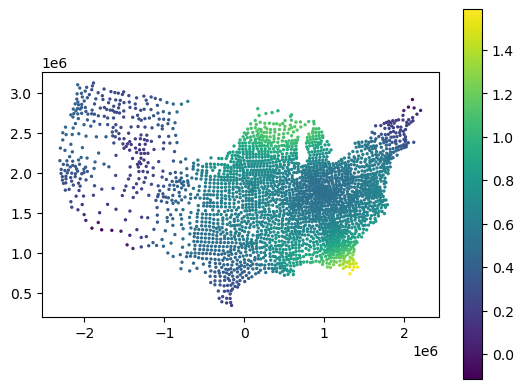

In [41]:
gdf.plot(gwlr.local_coef_["HR90"], legend=True, s=2)

Local intercepts

<Axes: >

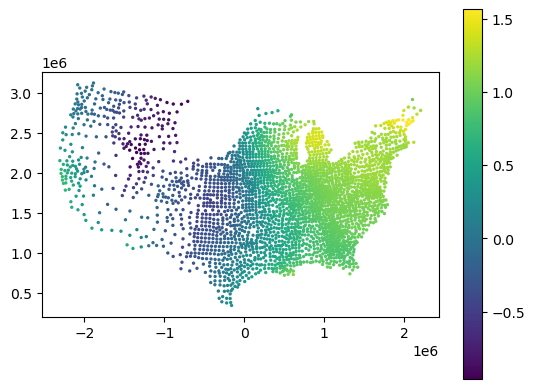

In [ ]:
gdf.plot(gwlr.local_intercept_, s=2, legend=True)

## Bandwidth search

Golden section search with a fixed distance bandwidth.

In [ ]:
search = BandwidthSearch(
    GWLogisticRegression,
    geometry=gdf.geometry,
    fixed=True,
    n_jobs=-1,
    search_method="golden_section",
    criterion="aic",
    max_iterations=3,
    min_bandwidth=250_000,
    max_bandwidth=2_000_000,
    verbose=True,
    max_iter=500,
)
search.fit(
    gdf.iloc[:, 9:15],
    y,
)

Fitting bandwidth: 918447.5
-0.4081785661481215 2918 6
Bandwidth: 918447.5, Score: 12.816
Fitting bandwidth: 1331552.5
-0.4112848331214553 3073 6
Bandwidth: 1331552.5, score: 12.823


Get the optimal one.

In [ ]:
search.scores_

918447.5     12.816357
1331552.5    12.822570
Name: oob_score, dtype: float64

Golden section search with an adaptive KNN bandwidth.

In [36]:
search = BandwidthSearch(
    GWLogisticRegression,
    geometry=gdf.geometry,
    fixed=False,
    n_jobs=-1,
    search_method="interval",
    min_bandwidth=50,
    max_bandwidth=1000,
    interval=100,
    criterion="aicc",
    verbose=True,
    max_iter=500,  # passed to log regr
)
search.fit(
    pd.DataFrame(
        preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
    ),
    y,
)

Bandwidth: 50.00, aicc: 3496.602
Bandwidth: 150.00, aicc: 2590.608
Bandwidth: 250.00, aicc: 2470.417
Bandwidth: 350.00, aicc: 2467.736
Bandwidth: 450.00, aicc: 2507.082
Bandwidth: 550.00, aicc: 2522.316
Bandwidth: 650.00, aicc: 2543.729
Bandwidth: 750.00, aicc: 2612.469
Bandwidth: 850.00, aicc: 2655.850
Bandwidth: 950.00, aicc: 2712.442


<Axes: >

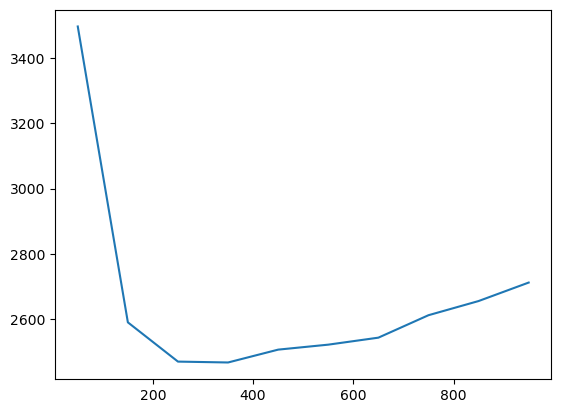

In [37]:
search.scores_.plot()

Get the optimal one.

In [42]:
search.optimal_bandwidth_

np.int64(350)

## Prediction

If you want to use the model for prediction, all the local models need to be retained. That may require significant memory for RF.

In [43]:
gwlr = GWLogisticRegression(
    geometry=gdf.geometry,
    bandwidth=918447,
    fixed=True,
    n_jobs=-1,
    verbose=True,
    max_iter=500,  # passed to log regr
    measure_performance=False,
    keep_models=True,
)
gwlr.fit(
    pd.DataFrame(
        preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
    ),
    gdf["FH90"] > gdf["FH90"].median(),
)

0.00s: Building weights
2.20s: Weights ready
2.20s: Fitting the models
8.81s: Models fitted
8.89s: Fitting global model
8.89s: Computing global likelihood
8.89s: Computing information criteria


/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,bandwidth,918447
,fixed,True
,kernel,'bisquare'
,include_focal,True
,geometry,0 PO...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,measure_performance,False
,strict,False
,keep_models,True


In [44]:
all_data = pd.DataFrame(
    preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
)

Predict probabilities

In [45]:
pp = gwlr.predict_proba(all_data.iloc[:10], geometry=gdf.geometry.iloc[:10])
pp

,False,True
0,0.820463,0.179537
1,0.622481,0.377519
2,0.692990,0.307010
3,0.650928,0.349072
4,0.718960,0.281040
5,0.759063,0.240937
6,0.642475,0.357525
7,0.773220,0.226780
8,0.533983,0.466017
9,0.785572,0.214428


Predict label (taking max of probabilities)

In [46]:
gwlr.predict(all_data.iloc[5:10], geometry=gdf.geometry.iloc[5:10])

5    False
6    False
7    False
8    False
9    False
dtype: bool

Exception ignored in: <function ResourceTracker.__del__ at 0x1073053a0>
Traceback (most recent call last):
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106c613a0>
Traceback (most recent call last):
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/m